In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import AutoTokenizer, AutoModel
import numpy as np
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/vibe/raw_data/twitter_MBTI.csv')

In [23]:
df = df[['text', 'label']]  # Keep only what's necessary
df.dropna(inplace=True)     # Drop rows with missing values

In [24]:
# Create one binary column for each MBTI letter
df['IE'] = df['label'].apply(lambda x: 1 if x[0] == 'i' else 0)
df['NS'] = df['label'].apply(lambda x: 1 if x[1] == 'n' else 0)
df['TF'] = df['label'].apply(lambda x: 1 if x[2] == 't' else 0)
df['JP'] = df['label'].apply(lambda x: 1 if x[3] == 'j' else 0)

In [25]:
import re

def clean_posts(text):
    # Sépare les tweets si concaténés par ||||
    tweets = text.split("||||")

    cleaned = []
    for tweet in tweets:
        # Supprime les mentions @utilisateur
        tweet = re.sub(r'@\w+', '', tweet)
        # Supprime les liens
        tweet = re.sub(r'http\S+', '', tweet)
        # Supprime les caractères non alphabétiques (en gardant les espaces)
        tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
        # Met en minuscules
        tweet = tweet.lower()
        # Supprime les espaces multiples
        tweet = re.sub(r'\s+', ' ', tweet).strip()
        cleaned.append(tweet)

    # Rejoint les tweets nettoyés en une seule chaîne
    return " ".join(cleaned)

In [26]:
df['clean_text'] = df['text'].apply(clean_posts)

In [27]:
df.head()

,text,label,IE,NS,TF,JP,clean_text
0,@Pericles216 @HierBeforeTheAC @Sachinettiyil T...,intj,1,1,1,1,the pope is infallible this is a catholic dogm...
1,@Hispanthicckk Being you makes you look cute||...,intj,1,1,1,1,being you makes you look cute on because then ...
2,@Alshymi Les balles sont réelles et sont tirée...,intj,1,1,1,1,les balles sont relles et sont tires trs rapid...
3,"I'm like entp but idiotic|||Hey boy, do you wa...",intj,1,1,1,1,im like entp but idiotichey boy do you want to...
4,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj,1,1,1,1,give it to he has pica since childhood say qub...


In [28]:
print(f"balance of the target ie : {df['IE'].value_counts(normalize=True)}")
print(f"balance of the target ns :{df['NS'].value_counts(normalize=True)}")
print(f"balance of the target tf :{df['TF'].value_counts(normalize=True)}")
print(f"balance of the target jp :{df['JP'].value_counts(normalize=True)}")

balance of the target ie : IE
1    0.671873
0    0.328127
Name: proportion, dtype: float64
balance of the target ns :NS
1    0.7725
0    0.2275
Name: proportion, dtype: float64
balance of the target tf :TF
0    0.588401
1    0.411599
Name: proportion, dtype: float64
balance of the target jp :JP
0    0.559083
1    0.440917
Name: proportion, dtype: float64


In [29]:
df['text_length_words'] = df['clean_text'].str.split().apply(len)

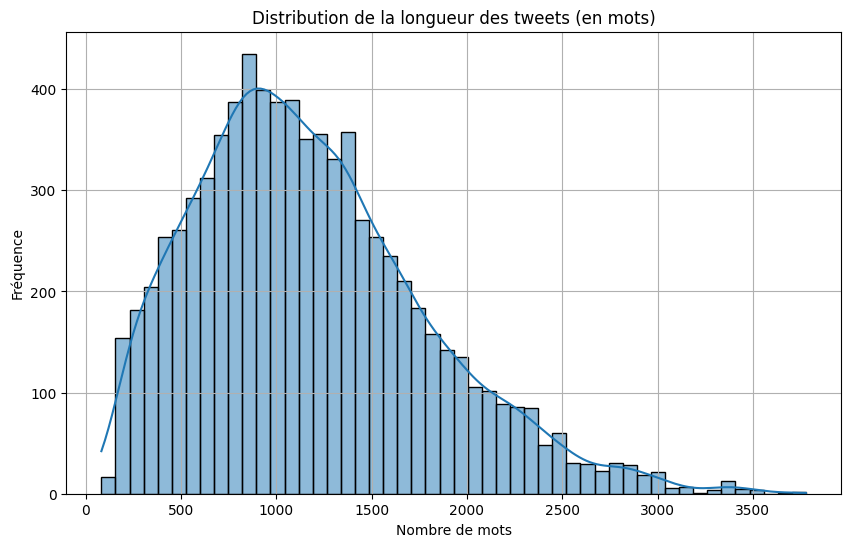

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['text_length_words'], bins=50, kde=True)
plt.title("Distribution de la longueur des tweets (en mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()

In [31]:
df = df[df['clean_text'].apply(lambda x: len(x.split()) < 1500 and len(x.split()) > 500)].reset_index(drop=True)

In [32]:
df.describe()

,IE,NS,TF,JP,text_length_words
count,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000
mean,0.664428,0.762434,0.405666,0.416999,996.609024
std,0.472240,0.425636,0.491072,0.493114,273.101713
min,0.000000,0.000000,0.000000,0.000000,501.000000
25%,0.000000,1.000000,0.000000,0.000000,774.000000
50%,1.000000,1.000000,0.000000,0.000000,989.000000
75%,1.000000,1.000000,1.000000,1.000000,1225.000000
max,1.000000,1.000000,1.000000,1.000000,1499.000000


In [33]:
df.head()

,text,label,IE,NS,TF,JP,clean_text,text_length_words
0,@Hispanthicckk Being you makes you look cute||...,intj,1,1,1,1,being you makes you look cute on because then ...,884
1,"I'm like entp but idiotic|||Hey boy, do you wa...",intj,1,1,1,1,im like entp but idiotichey boy do you want to...,916
2,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj,1,1,1,1,give it to he has pica since childhood say qub...,823
3,proud of this one it goes hard https://t.co/RQ...,intj,1,1,1,1,proud of this one it goes hard disgusting i am...,591
4,@Ieokuras so amazing!|||@hxhrats @ETTUKILLUG w...,intj,1,1,1,1,so amazing well mozart was a composer togashi ...,904


In [34]:
!pip install xgboost

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [44]:
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df["text"])

In [45]:
y_tf = df["TF"]
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X, y_tf, test_size=0.2, random_state=42)
model_tf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_tf.fit(X_train_tf, y_train_tf)
y_pred_tf = model_tf.predict(X_test_tf)
print(classification_report(y_test_tf, y_pred_tf))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:09:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.72      0.87      0.79       562
           1       0.73      0.52      0.60       391

    accuracy                           0.72       953
   macro avg       0.72      0.69      0.70       953
weighted avg       0.72      0.72      0.71       953



In [46]:
# Get feature importances
importances_tf = model_tf.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_tf = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_tf = list(zip(feature_names_tf, importances_tf))

# Sort by importance
word_importances_tf = sorted(word_importances_tf, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_tf[:20]:
    print(f"{word}: {importance:.4f}")

intp: 0.0092
entp: 0.0075
intj: 0.0062
happy: 0.0060
istp: 0.0057
infp: 0.0052
istj: 0.0047
entj: 0.0047
infj: 0.0045
and its: 0.0044
excited: 0.0044
so much: 0.0042
idk why: 0.0041
enfj: 0.0041
miku: 0.0039
like her: 0.0038
enfp: 0.0038
people on: 0.0038
mf: 0.0037
do it: 0.0037


In [47]:
y_ie = df["IE"]
X_train_ie, X_test_ie, y_train_ie, y_test_ie = train_test_split(X, y_ie, test_size=0.2, random_state=42)
model_ie = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_ie.fit(X_train_ie, y_train_ie)
y_pred_ie = model_ie.predict(X_test_ie)
print(classification_report(y_test_ie, y_pred_ie))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:10:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.73      0.50      0.60       313
           1       0.79      0.91      0.85       640

    accuracy                           0.78       953
   macro avg       0.76      0.71      0.72       953
weighted avg       0.77      0.78      0.76       953



In [48]:
# Get feature importances
importances_ie = model_ie.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_ie = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_ie = list(zip(feature_names_ie, importances_ie))

# Sort by importance
word_importances_ie = sorted(word_importances_ie, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_ie[:20]:
    print(f"{word}: {importance:.4f}")

entp: 0.0067
enfp: 0.0067
enfj: 0.0064
intp: 0.0049
infj: 0.0048
infp: 0.0047
become: 0.0047
entj: 0.0045
people on: 0.0042
would have: 0.0040
language: 0.0040
pack: 0.0039
and was: 0.0039
mutual: 0.0036
estp: 0.0036
he literally: 0.0035
80: 0.0035
together: 0.0035
intj: 0.0034
to share: 0.0034


In [49]:
y_ns = df["NS"]
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X, y_ns, test_size=0.2, random_state=42)
model_ns = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_ns.fit(X_train_ns, y_train_ns)
y_pred_ns = model_ns.predict(X_test_ns)
print(classification_report(y_test_ns, y_pred_ns))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:13:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.82      0.35      0.49       214
           1       0.84      0.98      0.90       739

    accuracy                           0.84       953
   macro avg       0.83      0.66      0.70       953
weighted avg       0.83      0.84      0.81       953



In [50]:
# Get feature importances
importances_ns = model_ns.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_ns = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_ns = list(zip(feature_names_ns, importances_ns))

# Sort by importance
word_importances_ns = sorted(word_importances_ns, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_ns[:20]:
    print(f"{word}: {importance:.4f}")

he looked: 0.0066
istp: 0.0062
isfj: 0.0061
about the: 0.0060
and im: 0.0057
isfp: 0.0056
without: 0.0055
esfp: 0.0055
infp: 0.0053
istj: 0.0051
quackity: 0.0050
ryujin: 0.0049
cheers: 0.0046
you think: 0.0046
era: 0.0045
intj: 0.0044
deserved: 0.0044
amp: 0.0043
enfp: 0.0041
intp: 0.0040


In [40]:
y = df["NS"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Dealing with class imbalanced
num_pos = sum(y_train)
num_neg = len(y_train) - num_pos
scale = num_neg / num_pos

model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=scale  # 👈 Boosts minority class
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:04:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.58      0.41      0.48       214
           1       0.84      0.91      0.88       739

    accuracy                           0.80       953
   macro avg       0.71      0.66      0.68       953
weighted avg       0.78      0.80      0.79       953



In [51]:
y_jp = df["JP"]
X_train_jp, X_test_jp, y_train_jp, y_test_jp = train_test_split(X, y_jp, test_size=0.2, random_state=42)
model_jp = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_jp.fit(X_train_jp, y_train_jp)
y_pred_jp = model_jp.predict(X_test_jp)
print(classification_report(y_test_jp, y_pred_jp))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:15:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.72      0.84      0.77       532
           1       0.74      0.59      0.66       421

    accuracy                           0.73       953
   macro avg       0.73      0.71      0.72       953
weighted avg       0.73      0.73      0.72       953



In [52]:
# Get feature importances
importances_jp = model_ns.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_jp = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_jp = list(zip(feature_names_jp, importances_jp))

# Sort by importance
word_importances_jp = sorted(word_importances_jp, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_jp[:20]:
    print(f"{word}: {importance:.4f}")

he looked: 0.0066
istp: 0.0062
isfj: 0.0061
about the: 0.0060
and im: 0.0057
isfp: 0.0056
without: 0.0055
esfp: 0.0055
infp: 0.0053
istj: 0.0051
quackity: 0.0050
ryujin: 0.0049
cheers: 0.0046
you think: 0.0046
era: 0.0045
intj: 0.0044
deserved: 0.0044
amp: 0.0043
enfp: 0.0041
intp: 0.0040
